In [139]:
import sys
sys.path.append("..")

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [140]:
from hpl.utils.postprocessing import (
    load_data_assimilation_network, 
    load_hydra_config,
    reconstruct_observations,
)
from hpl.datamodule.DataLoader import L96InferenceDataset
from hpl.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [141]:
experiment_dir = "/gpfs/work/zinchenk/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"
drop_edge_samples = False

In [142]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [143]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [146]:
torch.manual_seed(random_seed)
pl.seed_everything(random_seed)

# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
)

# instantiate dataset
dataset = L96InferenceDataset(
    ground_truth_data=test_simulations,
    observation_model=observational_model,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=drop_edge_samples,
)

print(f"Number of samples: {len(dataset)}")

Global seed set to 2510


Number of samples: 1000


In [137]:
def prepare_fields_and_statistics(
    observations_length: int, 
    forecast_length: int,
    dataset: L96InferenceDataset,
    assimilation_network: torch.nn.Module,
    config: dict,
):
    n_timesteps = observations_length + forecast_length
    
    # slice ground truth and observations to cpu
    ground_truth = dataset.ground_truth[:, :n_timesteps].cpu()
    observations = dataset.observations[:, :observations_length].cpu()
    # replace missing values with np.nan
    is_missing = torch.eq(observations, 0.)
    observations = observations.masked_fill(is_missing, np.nan)

    analysis = reconstruct_observations(dataset, assimilation_network)
    initial_conditions = analysis[:, -observations]
    analysis_and_forecast = torch.full_like(ground_truth, np.nan)
    # insert part of the reconstruction
    li = config.input_window_extend
    ri = observations_length - config.input_window_extend
    analysis_and_forecast[:, li:ri] = reconstructions[:, :ri-li].cpu()

    # insert forecast from estimated initial state
    initial_state = analysis_and_forecast[:, ri-1]
    forward_operator = L96Simulator(forcing=8.0)
    n_steps = analysis_and_forecast.shape[1] - ri
    time = torch.arange(0, n_steps*0.01, 0.01)
    rollout = forward_operator.integrate(time=time, state=initial_state).squeeze()
    analysis_and_forecast[:, ri:] = rollout

    difference = ground_truth[:, li:] - analysis_and_forecast[:, li:]
    difference = torch.full_like(ground_truth, np.nan)
    difference[:, li:] = ground_truth[:, li:] - analysis_and_forecast[:, li:]

    return ground_truth, observations, analysis_and_forecast, difference

IndentationError: expected an indented block (2569274753.py, line 6)

In [86]:
i_test_case = 10
integration_window = 150
forecast_window = 150

n_timesteps = integration_window + forecast_window

ground_truth = dataset.ground_truth[i_test_case, :n_timesteps].cpu()

observations = torch.zeros_like(ground_truth)
observations[:integration_window] = dataset.observations[i_test_case, :integration_window].cpu()
# cover missing values with np.nan
is_missing = torch.eq(observations, 0.)
observations = observations.masked_fill(is_missing, np.nan)


analysis_and_forecast = torch.full_like(ground_truth, np.nan)
# insert part of the reconstruction
li = config.input_window_extend
ri = integration_window - config.input_window_extend
analysis_and_forecast[li:ri] = reconstructions[i_test_case, :ri-li].cpu()

# insert forecast from estimated initial state
initial_state = analysis_and_forecast[ri-1]
forward_operator = L96Simulator(forcing=8.0)
n_steps = len(analysis_and_forecast) - ri
time = torch.arange(0, n_steps*0.01, 0.01)
rollout = forward_operator.integrate(time=time, state=initial_state.unsqueeze(0)).squeeze()
analysis_and_forecast[ri:] = rollout

tmp = torch.stack([ground_truth, observations, analysis_and_forecast])
vmin = torch.nan_to_num(tmp, nan=10e14).min()
vmax = torch.nan_to_num(tmp, nan=0).max()

squered_errors = (analysis_and_forecast[li:] - ground_truth[li:])**2
rmse_per_time_step = torch.full((ground_truth.size(0),), np.nan)
rmse_per_time_step[li:] = squered_errors.mean((-1)).sqrt()

difference = ground_truth[li:] - analysis_and_forecast[li:]
vlim = difference.abs().max()
difference = torch.full_like(ground_truth, np.nan)
difference[li:] = ground_truth[li:] - analysis_and_forecast[li:]

/tmp/ipykernel_124975/2149264723.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtickslabels)


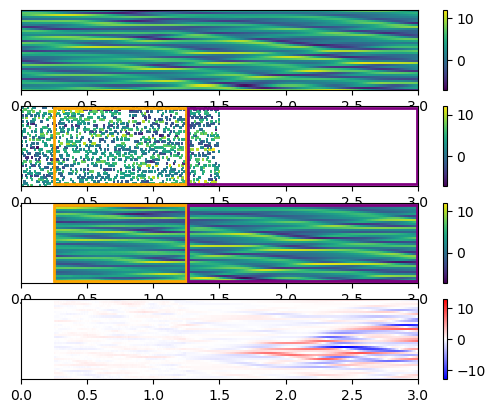

In [19]:
fig, axes = plt.subplots(4, 1)

img_gt = axes[0].pcolor(ground_truth.T, vmin=vmin, vmax=vmax)
img_obs = axes[1].pcolor(observations.T, vmin=vmin, vmax=vmax)
img_pred = axes[2].pcolor(analysis_and_forecast.T, vmin=vmin, vmax=vmax)

obs_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
obs_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[1].add_patch(obs_reconstraction_box)
axes[1].add_patch(obs_forecast_box)

pred_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
pred_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[2].add_patch(pred_reconstraction_box)
axes[2].add_patch(pred_forecast_box)


img_diff = axes[3].pcolor(difference.T, vmin=-vlim, vmax=vlim, cmap="bwr")

xticks = torch.arange(0, 301, 50)
xtickslabels = torch.arange(0, 3.1, 0.5).numpy()
for ax in axes:
    ax.set_yticks([])
    ax.set_xticklabels(xtickslabels)

plt.colorbar(img_gt, ax=axes[0])
plt.colorbar(img_obs, ax=axes[1])
plt.colorbar(img_pred, ax=axes[2])
plt.colorbar(img_diff, ax=axes[3])

# plt.tight_layout()

In [20]:
"""
    Same as above but for all available test simulations
"""
integration_window = 150
forecast_window = 150

n_timesteps = integration_window + forecast_window

ground_truth = dataset.ground_truth[:, :n_timesteps].cpu()

observations = torch.zeros_like(ground_truth)
observations[:, :integration_window] = dataset.observations[:, :integration_window].cpu()
# cover missing values with np.nan
is_missing = torch.eq(observations, 0.)
observations = observations.masked_fill(is_missing, np.nan)


analysis_and_forecast = torch.full_like(ground_truth, np.nan)
# insert part of the reconstruction
li = config.input_window_extend
ri = integration_window - config.input_window_extend
analysis_and_forecast[:, li:ri] = reconstructions[:, :ri-li].cpu()

# insert forecast from estimated initial state
initial_state = analysis_and_forecast[:, ri-1]
forward_operator = L96Simulator(forcing=8.0)
n_steps = analysis_and_forecast.shape[1] - ri
time = torch.arange(0, n_steps*0.01, 0.01)
rollout = forward_operator.integrate(time=time, state=initial_state).squeeze()
analysis_and_forecast[:, ri:] = rollout

difference = ground_truth[:, li:] - analysis_and_forecast[:, li:]
difference = torch.full_like(ground_truth, np.nan)
difference[:, li:] = ground_truth[:, li:] - analysis_and_forecast[:, li:]

/tmp/ipykernel_124975/4230179426.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtickslabels)


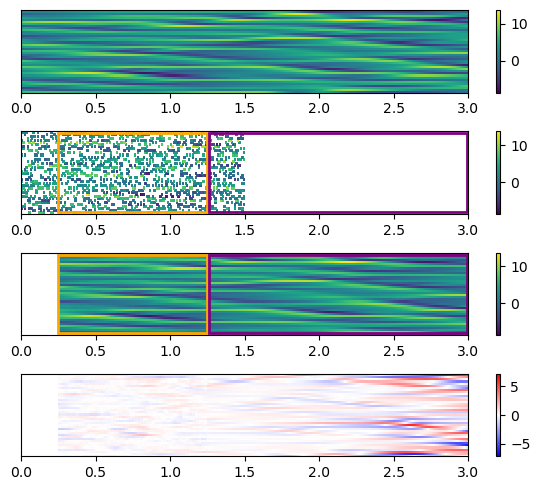

In [68]:
i_simulation = 1

fig, axes = plt.subplots(4, 1, figsize=(6, 5))

img_gt = axes[0].pcolor(ground_truth[i_simulation].T, vmin=vmin, vmax=vmax)
img_obs = axes[1].pcolor(observations[i_simulation].T, vmin=vmin, vmax=vmax)
img_pred = axes[2].pcolor(analysis_and_forecast[i_simulation].T, vmin=vmin, vmax=vmax)
tmp = torch.stack([ground_truth[i_simulation], observations[i_simulation], analysis_and_forecast[i_simulation]])
vmin = torch.nan_to_num(tmp, nan=10e14).min()
vmax = torch.nan_to_num(tmp, nan=0).max()

obs_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
obs_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[1].add_patch(obs_reconstraction_box)
axes[1].add_patch(obs_forecast_box)

pred_reconstraction_box = patches.Rectangle((25, 1), 100, 38, linewidth=2, edgecolor='orange', facecolor='none', zorder=999)
pred_forecast_box = patches.Rectangle((126, 1), 173, 38, linewidth=2, edgecolor='purple', facecolor='none', zorder=999)
axes[2].add_patch(pred_reconstraction_box)
axes[2].add_patch(pred_forecast_box)

vlim = torch.nan_to_num(difference[i_simulation], nan=0).abs().max()
img_diff = axes[3].pcolor(difference[i_simulation].T, vmin=-vlim, vmax=vlim, cmap="bwr")

xticks = torch.arange(0, 301, 50)
xtickslabels = torch.arange(0, 3.1, 0.5).numpy()
for ax in axes:
    ax.set_yticks([])
    ax.set_xticklabels(xtickslabels)

plt.colorbar(img_gt, ax=axes[0])
plt.colorbar(img_obs, ax=axes[1])
plt.colorbar(img_pred, ax=axes[2])
plt.colorbar(img_diff, ax=axes[3])

plt.tight_layout()

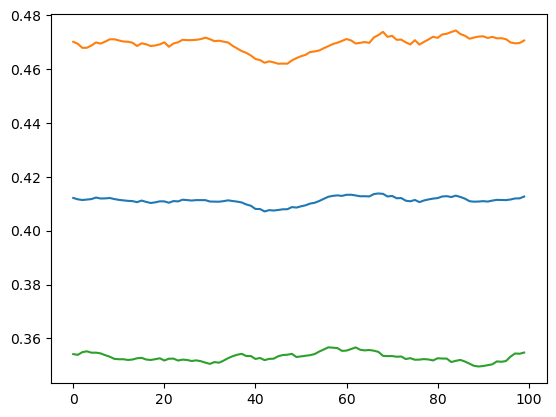

In [60]:
squered_errors = (reconstructions[:, :ri-li].cpu() - ground_truth[:, li:ri].cpu())**2
reconstruction_mean_errors = squered_errors.mean((-1, 0)).sqrt()
reconstruction_std_errors = squered_errors.mean((-1)).sqrt().std((0))

plt.plot(reconstruction_mean_errors)
plt.plot(reconstruction_mean_errors+reconstruction_std_errors)
plt.plot(reconstruction_mean_errors-reconstruction_std_errors)

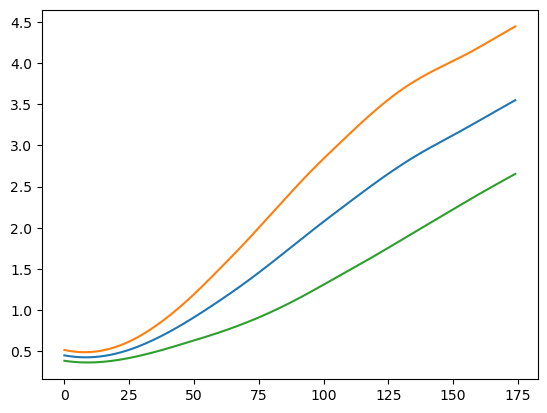

In [72]:
squered_errors = (analysis_and_forecast[:, ri:].cpu() - ground_truth[:, ri:].cpu())**2
reconstruction_mean_errors = squered_errors.mean((-1, 0)).sqrt()
reconstruction_std_errors = squered_errors.mean((-1)).sqrt().std((0))

plt.plot(reconstruction_mean_errors)
plt.plot(reconstruction_mean_errors+reconstruction_std_errors)
plt.plot(reconstruction_mean_errors-reconstruction_std_errors)

In [118]:
xticks = torch.arange(0, 301, 50)
xtickslabels = torch.arange(0, 3.1, 0.5).numpy()

/tmp/ipykernel_124975/3520904829.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["a"].set_xticklabels(xtickslabels)
/tmp/ipykernel_124975/3520904829.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["b"].set_xticklabels(xtickslabels)
/tmp/ipykernel_124975/3520904829.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["c"].set_xticklabels(xtickslabels)
/tmp/ipykernel_124975/3520904829.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd["d"].set_xticklabels(xtickslabels)


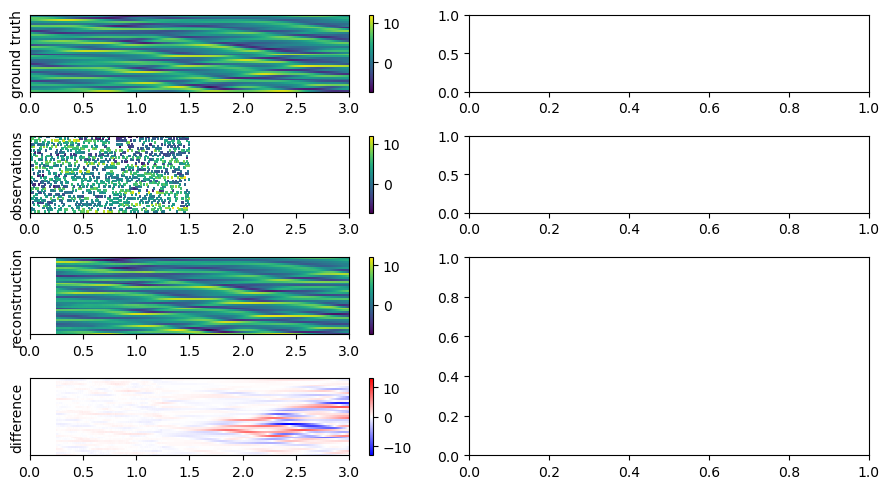

In [123]:
mosaic = """
aaee
bbff
ccgg
ddgg
"""
fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(9, 5))

# A - ground truth simulation
img_gt = axd["a"].pcolor(ground_truth.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_gt, ax=axd["a"])
axd["a"].set_xticklabels(xtickslabels)
axd["a"].set_ylabel("ground truth")
axd["a"].tick_params(left=False, labelleft=False)

# B - pseudo-observations
img_obs = axd["b"].pcolor(observations.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_obs, ax=axd["b"])
axd["b"].set_xticklabels(xtickslabels)
axd["b"].set_ylabel("observations")
axd["b"].tick_params(left=False, labelleft=False)

# C - reconstruction and forecast
img_pred = axd["c"].pcolor(analysis_and_forecast.T, vmin=vmin, vmax=vmax)
plt.colorbar(img_pred, ax=axd["c"])
axd["c"].set_xticklabels(xtickslabels)
axd["c"].set_ylabel("reconstruction")
axd["c"].tick_params(left=False, labelleft=False)

# D - difference between groud truth and reconstraction/forecast
vlim = torch.nan_to_num(difference, nan=0).abs().max()
img_diff = axd["d"].pcolor(difference.T, vmin=-vlim, vmax=vlim, cmap="bwr")
plt.colorbar(img_diff, ax=axd["d"])
axd["d"].set_xticklabels(xtickslabels)
axd["d"].set_ylabel("difference")
axd["d"].tick_params(left=False, labelleft=False)

# E - initial condition error
estimated_initial_state = initial_state
true_initial_state = all_ground_truth[:, ri-1]


plt.tight_layout()

In [ ]:

# for ax in axes:
#     ax.set_yticks([])
#     ax.set_xticklabels(xtickslabels)